<a href="https://colab.research.google.com/github/anruki/Quantum-Programming/blob/main/qiskit_102_9_10_24_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
pip install qiskit_ibm_runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.3/343.3 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 8.7 MB/s eta 0:00:00


In [2]:
pip install qiskit[visualization]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 6.7 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=f7cc5177b52e97f479f65cbecb53026103bdc165e99d06d77c5b039d067c31d0
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


# Qiskit 102: Building a Qiskit pattern workflow

## Step 1: Map classical problem to quantum circuits and observables

In [3]:
import rustworkx as rx
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.circuit.library import RZZGate, RXGate


def max_cut_hamiltonian(graph: rx.PyGraph) -> SparsePauliOp:
    terms = [["", [], 0.5 * graph.num_edges()]]
    for edge in graph.edge_list():
        terms.append(["ZZ", edge, -0.5])
    return SparsePauliOp.from_sparse_list(terms, num_qubits=graph.num_nodes())


def qaoa_circuit(graph: rx.PyGraph, p: int) -> QuantumCircuit:
    betas = [Parameter(f"b_{i}") for i in range(p)]
    gammas = [Parameter(f"g_{i}") for i in range(p)]
    qubits = QuantumRegister(graph.num_nodes())
    circuit = QuantumCircuit(qubits)
    circuit.h(qubits)
    for beta, gamma in zip(betas, gammas):
        for (i, j) in graph.edge_list():
            circuit.append(RZZGate(gamma), [qubits[i], qubits[j]])
        for q in qubits:
            circuit.append(RXGate(beta), [q])
    return circuit


n_qubits = 5
probability = 0.8
p = 1

graph = rx.undirected_gnp_random_graph(num_nodes=n_qubits, probability=probability)
observable = max_cut_hamiltonian(graph)
circuit = qaoa_circuit(graph, p=p)

In [4]:
observable

SparsePauliOp(['IIIII', 'IIIZZ', 'IIZIZ', 'IIZZI', 'IZIZI', 'ZIIIZ', 'ZIIZI', 'ZZIII'],
              coeffs=[ 3.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,
 -0.5+0.j])

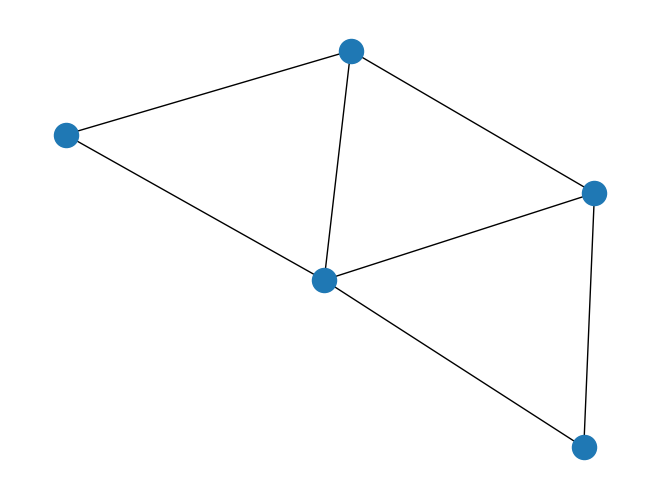

In [5]:
from rustworkx.visualization import mpl_draw

mpl_draw(graph)

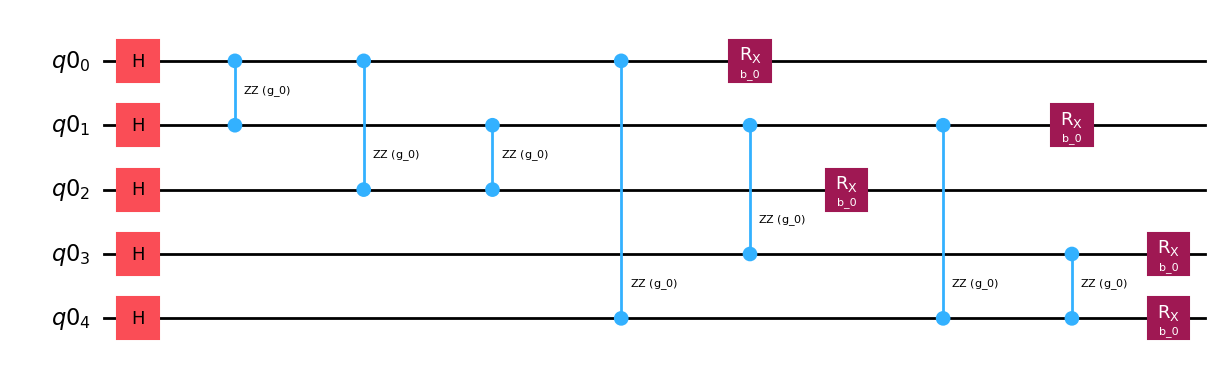

In [6]:
circuit.draw("mpl")

## Step 2: Optimize problem for execution on quantum hardware

In [9]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend = FakeSherbrooke()

pass_manager = generate_preset_pass_manager(
    optimization_level=3,
    backend=backend,
    # initial_layout=[0, 1, 2, 3, 4],
)

isa_circuit = pass_manager.run(circuit)
isa_observable = observable.apply_layout(isa_circuit.layout)

In [10]:
observable

SparsePauliOp(['IIIII', 'IIIZZ', 'IIZIZ', 'IIZZI', 'IZIZI', 'ZIIIZ', 'ZIIZI', 'ZZIII'],
              coeffs=[ 3.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,
 -0.5+0.j])

In [11]:
isa_observable

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

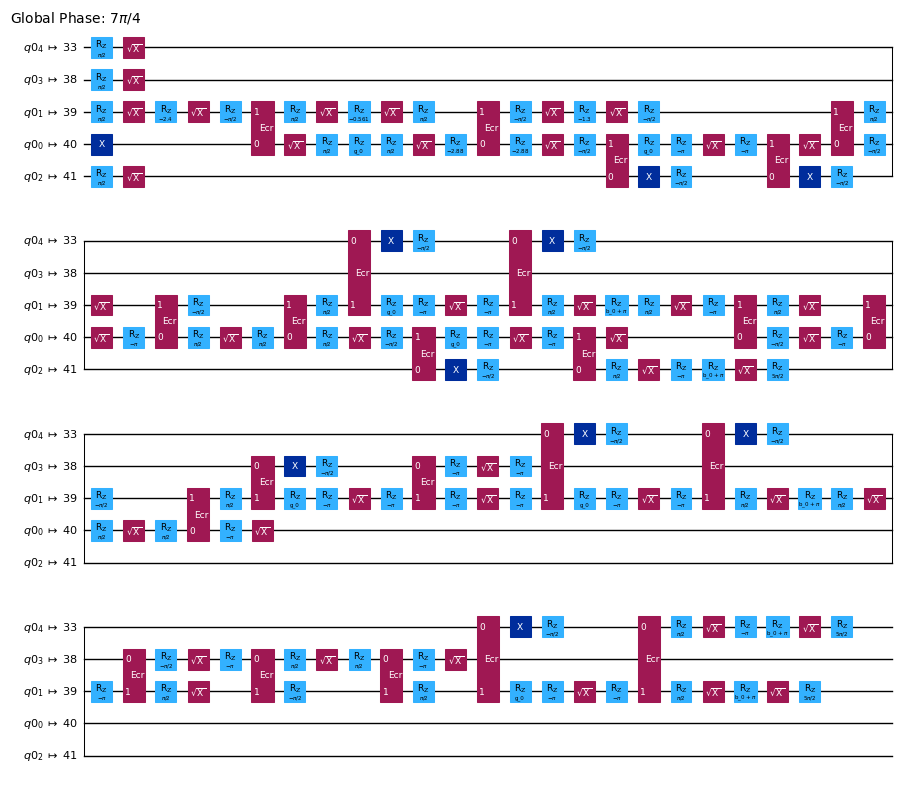

In [12]:
isa_circuit.draw("mpl", idle_wires=False, scale=0.5)

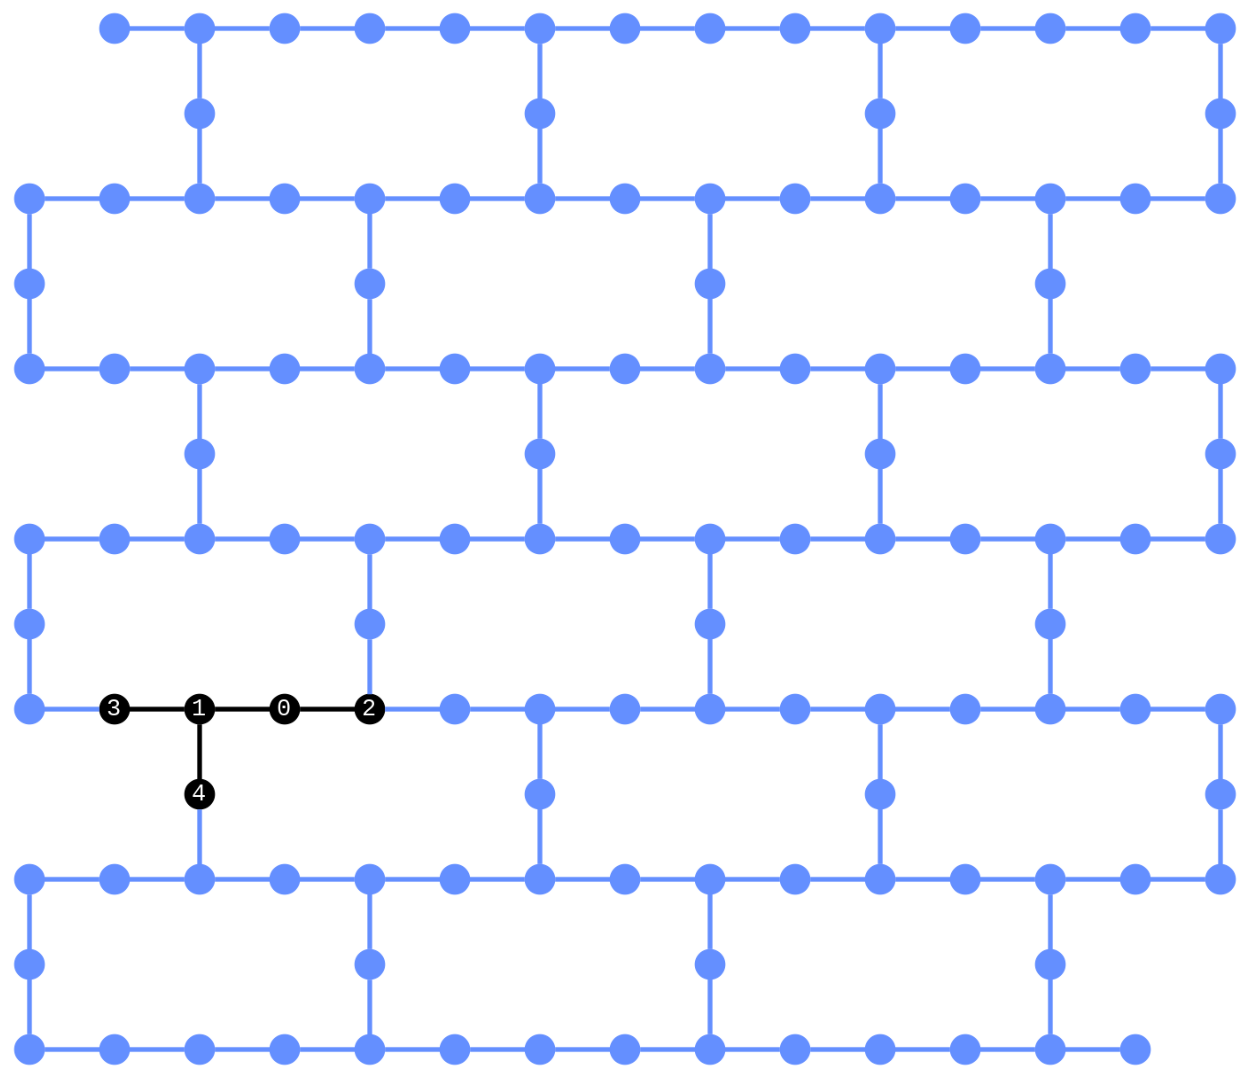

In [13]:
from qiskit.visualization import plot_circuit_layout

plot_circuit_layout(isa_circuit, backend)

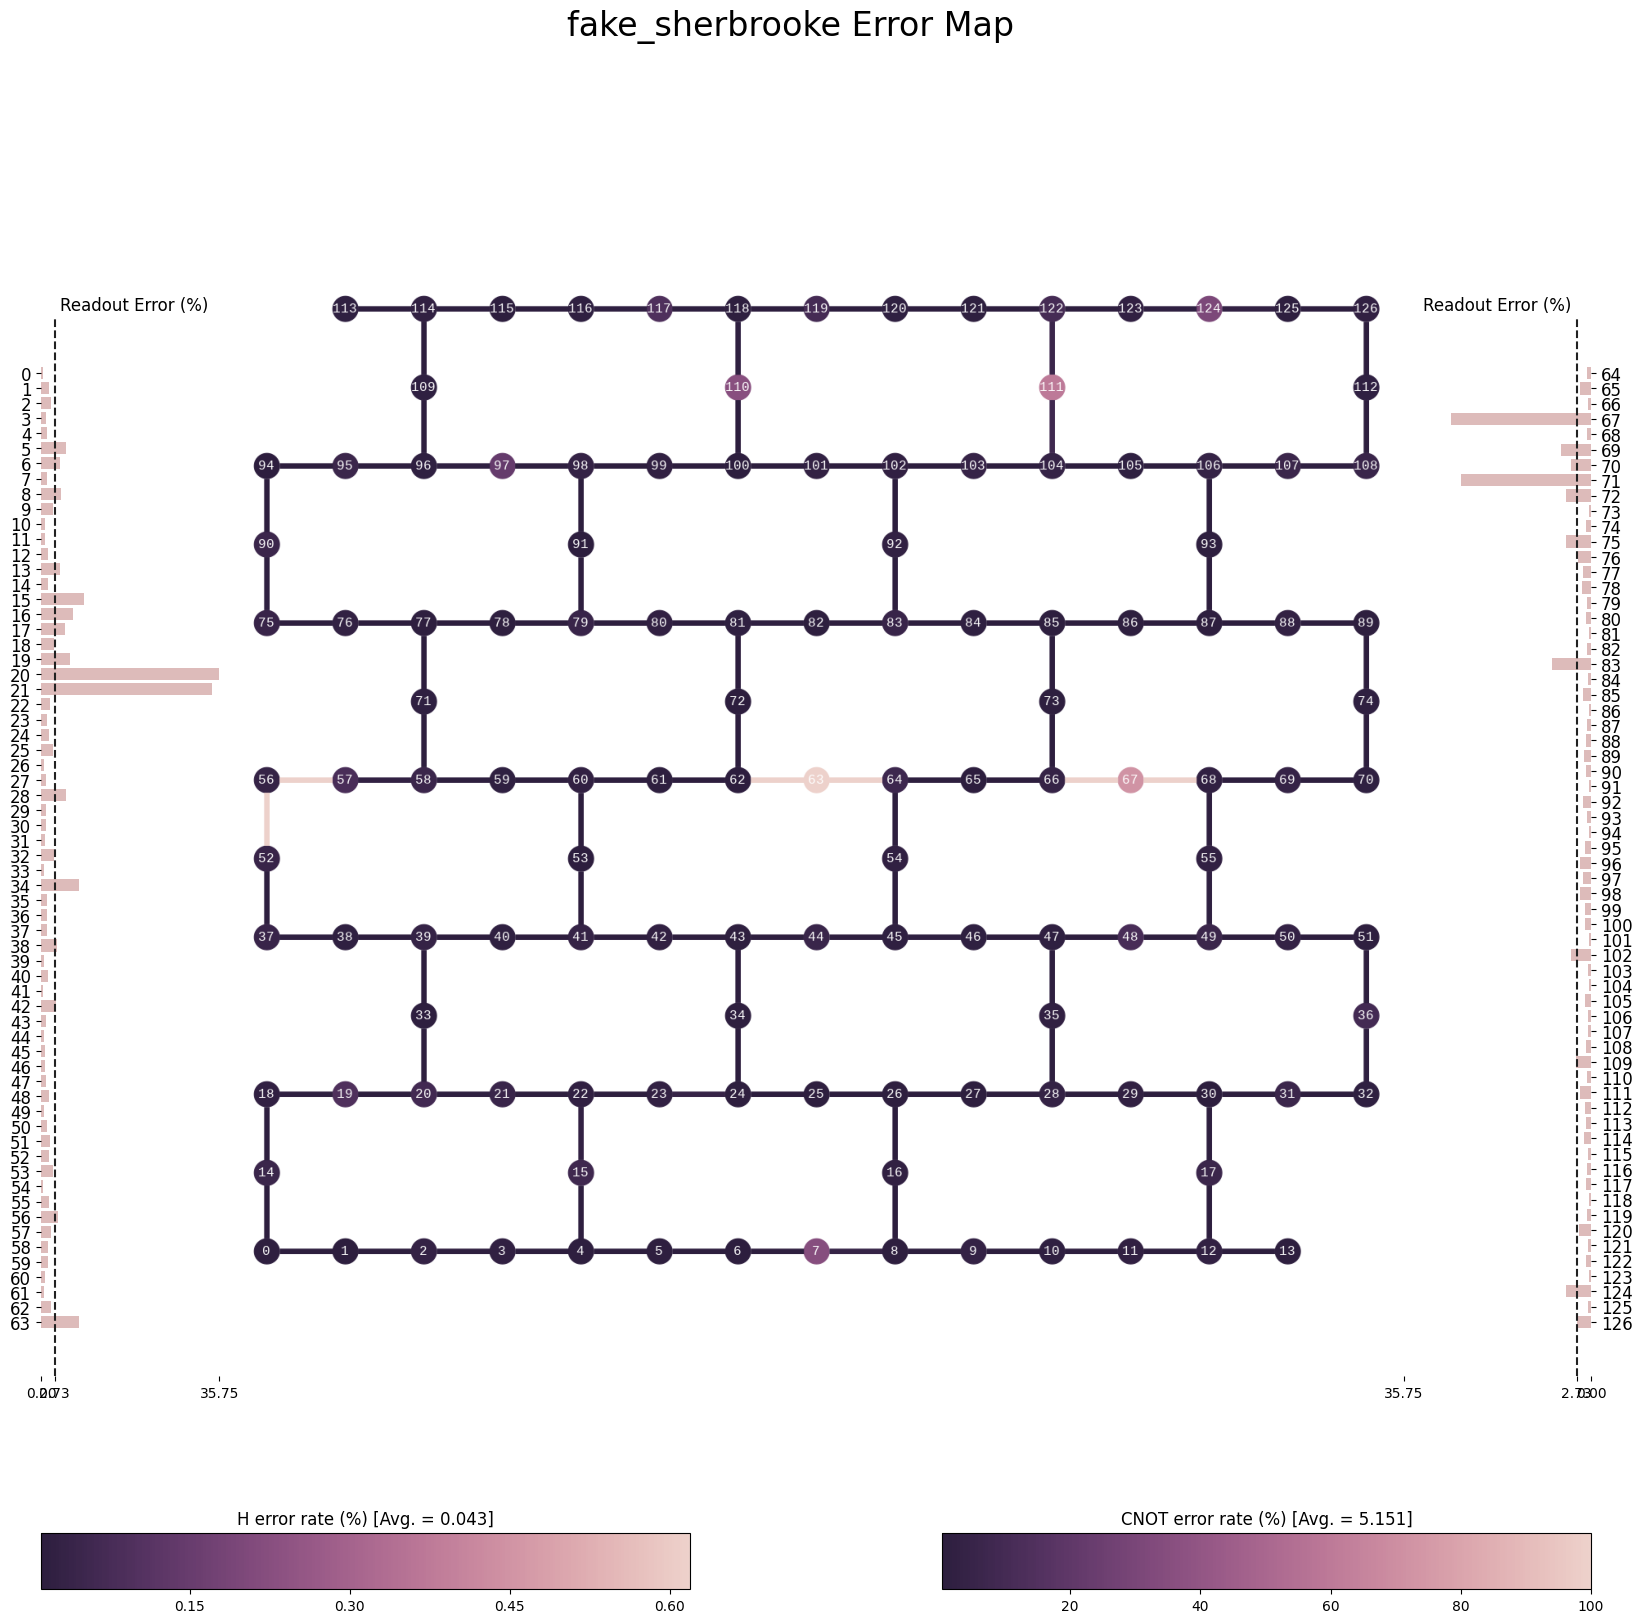

In [14]:
from qiskit.visualization import plot_error_map

plot_error_map(backend, figsize=(20, 20))

## Step 3: Execute circuits using Qiskit Primitives

In [17]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
import numpy as np

rng = np.random.default_rng()
params = rng.uniform(-np.pi, np.pi, size=circuit.num_parameters)


estimator = Estimator(backend=backend)

pub = (isa_circuit, isa_observable, params)
job = estimator.run([pub])

TypeError: EstimatorV2.__init__() got an unexpected keyword argument 'backend'

In [18]:
result = job.result()
pub_result = result[0]
expectation_val = float(pub_result.data.evs)
expectation_val

NameError: name 'job' is not defined

In [ ]:
from qiskit_ibm_runtime import Session
import scipy.optimize


def f(x: np.ndarray, estimator: Estimator) -> float:
    pub = (isa_circuit, isa_observable, x)
    job = estimator.run([pub])
    result = job.result()
    pub_result = result[0]
    val = -float(pub_result.data.evs)
    print(f"Objective function value: {val}")
    return val


with Session(backend=backend):
    estimator = Estimator(backend=backend)
    result = scipy.optimize.minimize(
        f, params, args=(estimator,), method="COBYLA", options=dict(maxiter=5)
    )

/home/kjs/.pyenv/versions/3.12.3/envs/qiskit-101-102/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


Objective function value: -4.34033203125
Objective function value: -1.8408203125
Objective function value: -5.486328125
Objective function value: -3.85888671875
Objective function value: -5.20068359375


In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# params = result.x

sampler = Sampler(backend=backend)

circuit_with_meas = circuit.copy()
circuit_with_meas.measure_all()
isa_circuit = pass_manager.run(circuit_with_meas)

pub = (isa_circuit, params)
job = sampler.run([pub])
result = job.result()
pub_result = result[0]
pub_result

PubResult(data=DataBin<>(meas=BitArray(<shape=(), num_shots=1024, num_bits=5>)))

## Step 4: Postprocess results into classical format

In [ ]:
counts = pub_result.data.meas.get_counts()

bitstring = max(counts, key=lambda x: counts[x])

In [ ]:
def cut_size(bitstring: str, graph: rx.PyGraph) -> int:
    return sum(bitstring[-i-1] != bitstring[-j-1] for i, j in graph.edge_list())

cut_size(bitstring, graph)

6

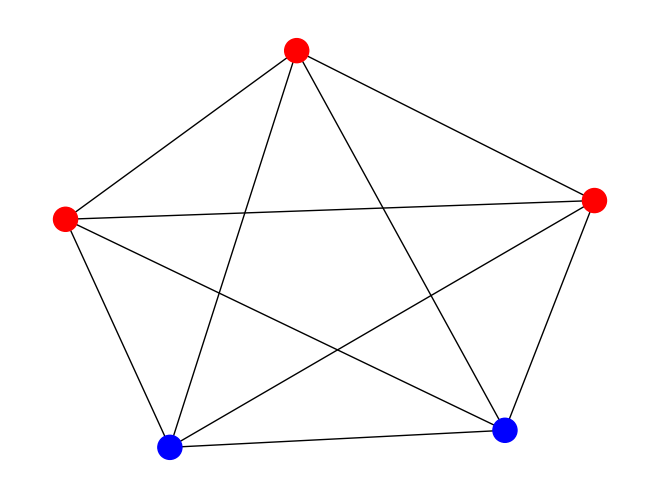

In [ ]:
colors = ["red" if b == "0" else "blue" for b in bitstring]

mpl_draw(graph, node_color=colors)